In [1]:
import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import os
import sys
sys.path.append('../src/img/')
from img_utils import MaskedClassifier
from approx_ss_rate import sampling_algo
from explns import *

import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, X):
        return self.model(X).logits

In [3]:
torch.set_grad_enabled(False)

# model path
model_name = 'google/vit-base-patch16-224'

orig_model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

model = WrappedModel(orig_model)
model = model.cuda()

# data paths
TRAIN_DATA_DIR = '/shared_data0/exlib/imagenet/data/train'
VAL_DATA_DIR = '/shared_data0/exlib/imagenet/data/val'

# Load the dataset
# train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)

#train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=True, generator=torch.Generator().manual_seed(50))
for X,y in test_dataloader: 
    X = X.cuda()
    y = y.cuda()
    break

In [4]:
# plt.imshow(X[0].cpu().permute(1,2,0))

In [5]:
expln_name = 'lime'
attrs_filepath = f"/shared_data0/helenjin/ssg/saved_outputs/img/{expln_name}_attrs_1000"

if os.path.exists(attrs_filepath):
    # get attributions
    attrs = torch.load(attrs_filepath)    

In [6]:
X = X[:100]
y = y[:100]
attrs = attrs[:100]
print(X.shape)

torch.Size([100, 3, 224, 224])


In [7]:
alpha_all = get_alpha_from_attrs(attrs)

In [8]:
model_f = MaskedClassifier(model)
r_max = 98
epsilon = 0.1

In [9]:
for i, x in enumerate(X):
    print('img', i)
    alpha = alpha_all[i]
    tau_all, mu_hat_k_list_all = sampling_algo(model_f, x, alpha, r=r_max, epsilon=epsilon)
    torch.save(tau_all, f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')
    torch.save(mu_hat_k_list_all, f'../saved_outputs/img/mu_hat_k_list_all/{expln_name}/img_{i}.pt')

img 0


  0%|          | 0/98 [00:00<?, ?it/s]

RuntimeError: Parent directory ../../saved_outputs/img/tau_all/lime does not exist.

Text(0, 0.5, 'Stability rate')

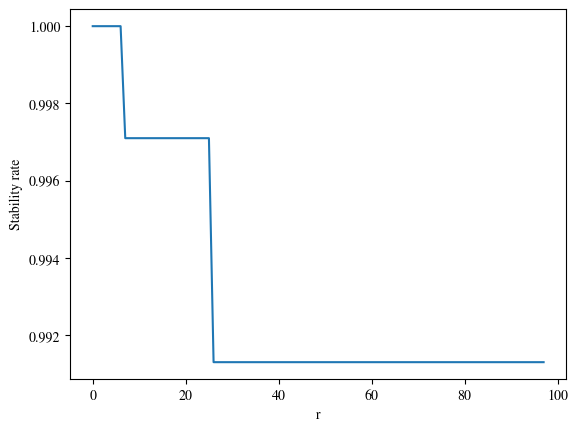

In [27]:
i = 0

tau_all = torch.load(f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')
mu_hat_k_list_all = torch.load(f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')

plt.plot(tau_all)
plt.xlabel('r')
plt.ylabel('Stability rate')

Text(0, 0.5, 'Stability rate')

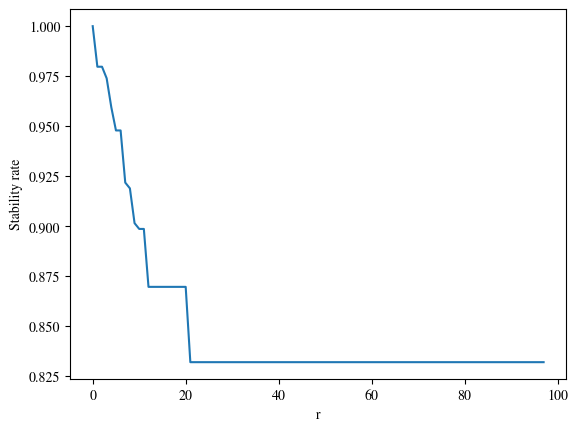

In [36]:
i = 13

tau_all = torch.load(f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')
mu_hat_k_list_all = torch.load(f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')

plt.plot(tau_all)
plt.xlabel('r')
plt.ylabel('Stability rate')

In [37]:
tau_all

[1.0,
 0.9797101616859436,
 0.9797101616859436,
 0.9739130735397339,
 0.9594203233718872,
 0.9478261470794678,
 0.9478261470794678,
 0.9217391610145569,
 0.9188405871391296,
 0.9014493227005005,
 0.8985507488250732,
 0.8985507488250732,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8695652484893799,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318840861320496,
 0.8318

In [91]:
# get avg of each example

tau_all_examples = []

for i in range(1000):
    tau_all_i = torch.load(f'../saved_outputs/img/tau_all/{expln_name}/img_{i}.pt')
    tau_all_examples.append(torch.tensor(tau_all_i))

tau_all_examples = torch.stack(tau_all_examples)


In [92]:
tau_all_examples.shape

torch.Size([1000, 98])

In [93]:
torch.mean(tau_all_examples, dim=0).shape

torch.Size([98])

Text(0, 0.5, 'Stability rate')

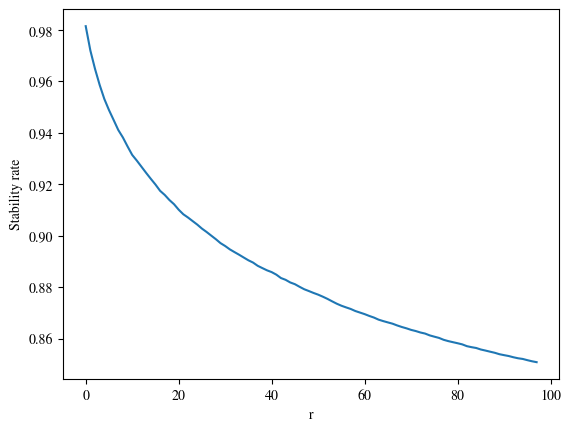

In [94]:
plt.plot(torch.mean(tau_all_examples, dim=0))
plt.xlabel('r')
plt.ylabel('Stability rate')

In [95]:
tau_all_examples.shape

torch.Size([1000, 98])

In [96]:
lambdas = [0.25, 0.5, 0.75, 1]
prop_all_curves = []
for threshold in lambdas:
    prop_all = [(tau_all_examples[:,i] > threshold).float().mean() for i in range(tau_all_examples.shape[1])]
    prop_all = torch.stack(prop_all)
    prop_all_curves.append(prop_all)

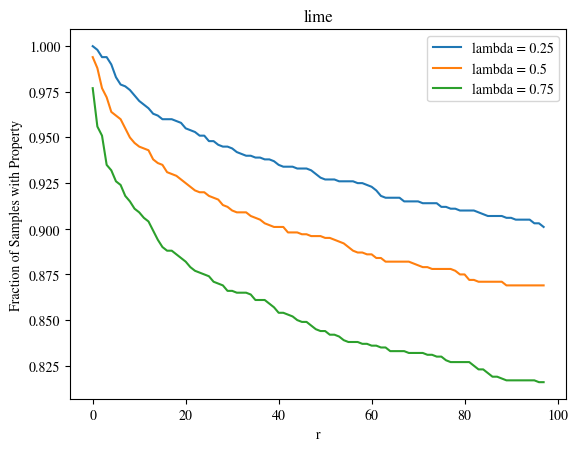

In [98]:
plt.plot(prop_all_curves[0])
plt.plot(prop_all_curves[1])
plt.plot(prop_all_curves[2])
# plt.plot(prop_all_curves[3])
plt.ylabel('Fraction of Samples with Property')
plt.xlabel('r')
plt.title('lime')
plt.legend(['lambda = 0.25', 'lambda = 0.5','lambda = 0.75'])#,'lambda = 1'])

plt.savefig(f'../figures/{expln_name}_experiment1', bbox_inches="tight")

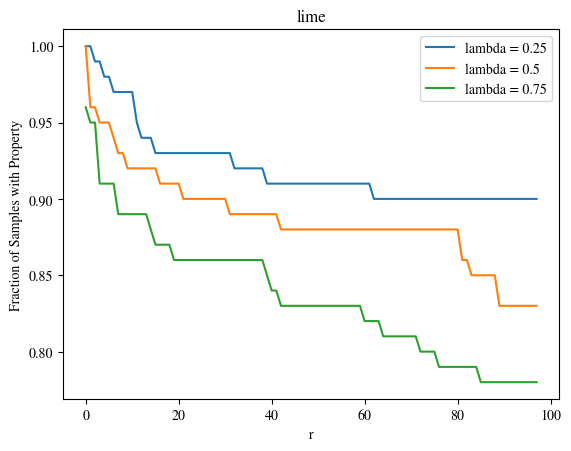

In [83]:
plt.plot(prop_all_curves[0])
plt.plot(prop_all_curves[1])
plt.plot(prop_all_curves[2])
# plt.plot(prop_all_curves[3])
plt.ylabel('Fraction of Samples with Property')
plt.xlabel('r')
plt.title('lime')
plt.legend(['lambda = 0.25', 'lambda = 0.5','lambda = 0.75'])#,'lambda = 1'])

plt.savefig(f'../figures/{expln_name}_experiment1')